# Example of usage Spark OCR for Tables Recognition with ImageToTextV3</br>(Case Sensitive)

This notebook demonstrate end-to-end pipeline for extract tabular data from image-based documents. We use ImageToTextV3 to keep case information.

For more details about table recognition please read: [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from sparkocr import start
import os


extra_conf = SparkConf()
extra_conf.set("spark.driver.memory", "20G")
extra_conf.set("spark.executor.memory", "20G")
extra_conf.set("spark.sql.legacy.allowUntypedScalaUDF", "true")

spark_ocr_jar_path = "../../target/scala-2.12"

spark = start(jar_path=spark_ocr_jar_path, extra_conf=extra_conf)
spark

Spark version: 3.4.0
Spark NLP version: 5.4.0
Spark NLP for Healthcare version: 5.3.2
Spark OCR version: 5.4.0




    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/PIIS0092867424005385__9.jpg
    Resolution: 150 dpi
    Width: 1257 px
    Height: 1632 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


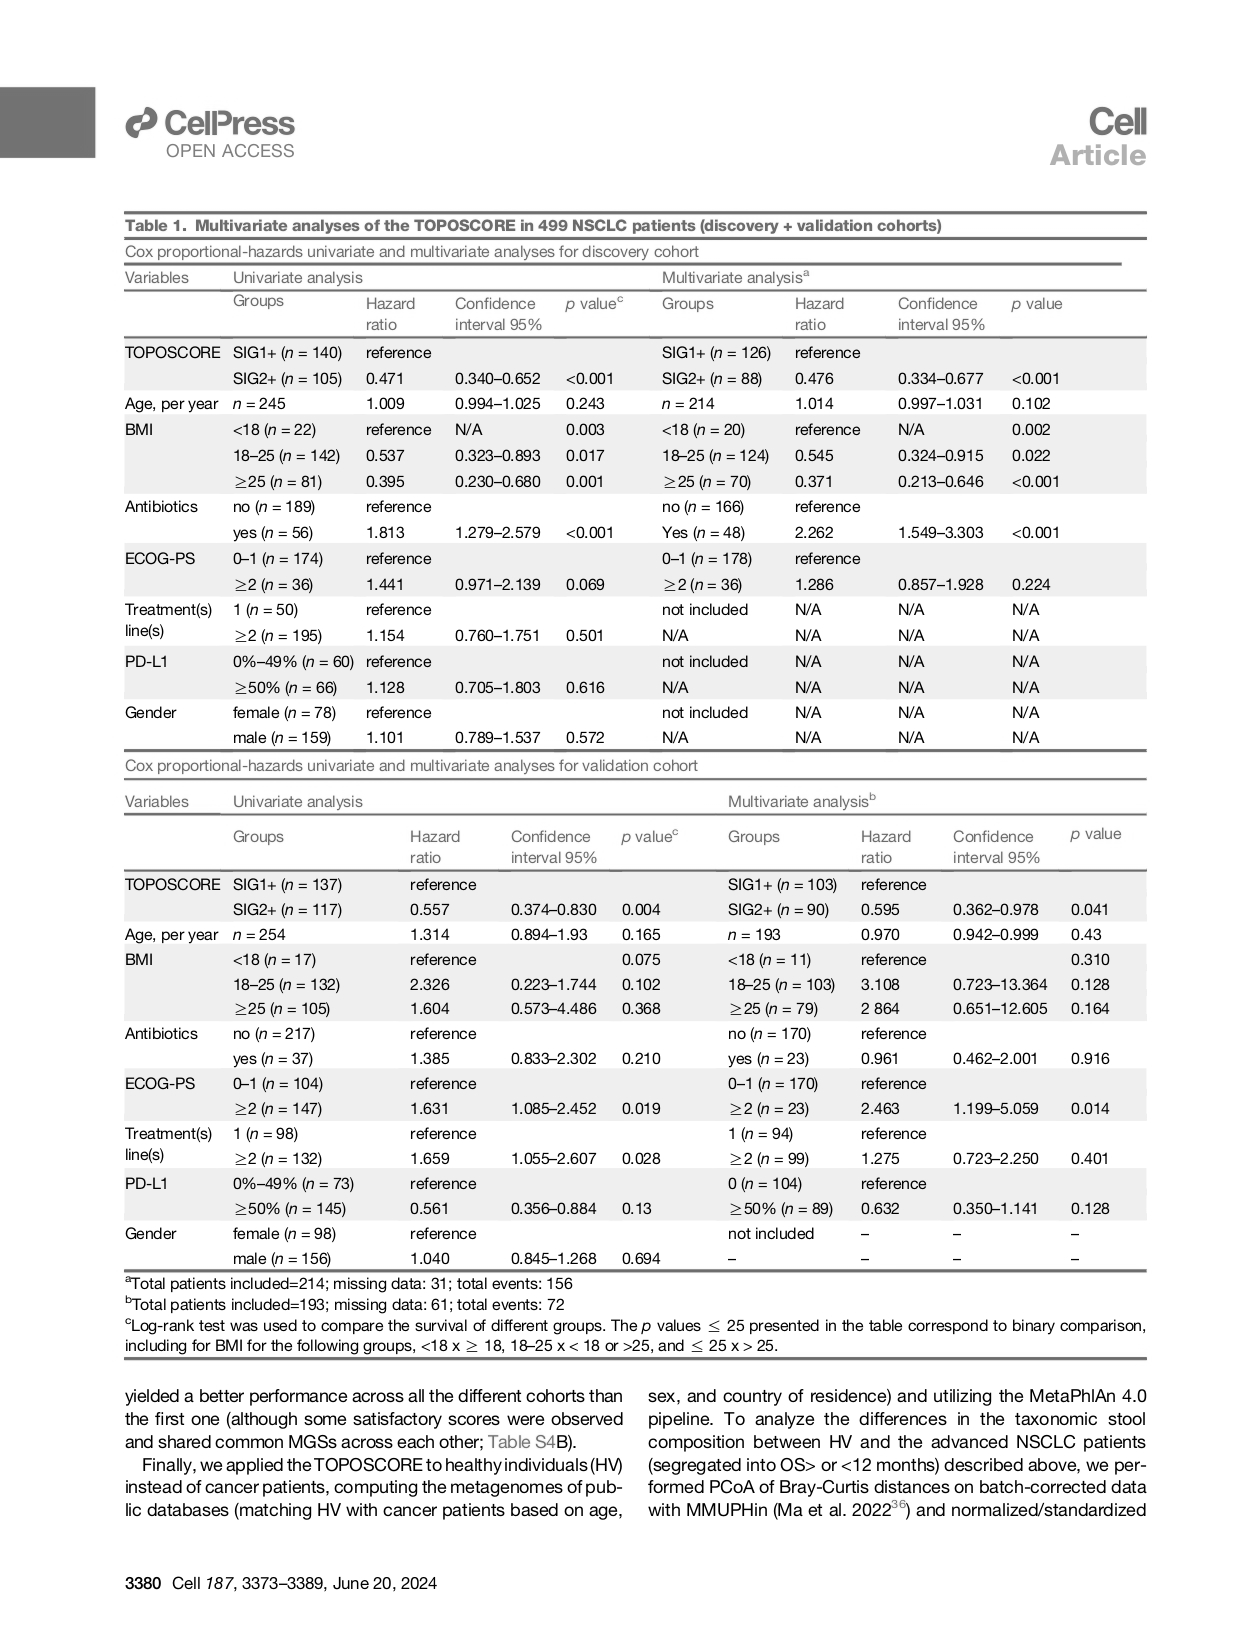

In [2]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_tables, display_table
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

imagePath = "./data/PIIS0092867424005385__9.jpg"
image_df= spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

In [3]:
binary_to_image = BinaryToImage() \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector \
    .pretrained("table_detection_v3", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("table_regions") \
    .setScoreThreshold(0.5) \
    .setApplyCorrection(True)

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("table_image") \
    .setDropCols("image")

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("table_image") \
    .setOutputCol("text_regions") \
    .setTextThreshold(0.4) \
    .setSizeThreshold(2) \
    .setScoreThreshold(0.4) \
    .setUseGPU(False)

cell_detector = ImageDocumentRegionDetector \
    .pretrained("region_cell_detection_v2", "en", "clinical/ocr") \
    .setInputCol("table_image") \
    .setOutputCol("cells") \
    .setScoreThreshold(0.8)

merger = RegionsMerger() \
    .setInputCols(["text_regions"]) \
    .setCellInputCol("cells") \
    .setImageInputCol("table_image") \
    .setOutputCol("merged_regions") \
    .setKeepTextRegions(True)

img_to_hocr = ImageToTextV3() \
    .setInputCols(["table_image", "merged_regions"]) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setOutputCol("hocr")

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setOutputCol("table") \
    .setUseCellsCol("cells")

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    cell_detector,
    merger,
    img_to_hocr,
    hocr_to_table
])

result = pipeline.transform(image_df).cache()
display(result)

table_detection_v3 download started this may take some time.
Approximate size to download 23.1 MB
image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
region_cell_detection_v2 download started this may take some time.
Approximate size to download 23.1 MB


text_regions,image,path,modificationTime,length,pagenum,table_regions,table_image,cells,merged_regions,hocr,positions,table,exception,table_index
"[{0, 0, 34.50078,...",{file:/home/jose/...,file:/home/jose/s...,2024-06-25 11:50:56,887850,0,"[{0, 0, 122.0, 77...",{file:/home/jose/...,"[{0, 0, 388.0, 51...","[{0, 0, 871.0, 57...","<div title=""bbox ...","[{[{Confidence, 8...","{{0, 0, 0.0, 0.0,...",null,0
"[{0, 0, 35.3375, ...",{file:/home/jose/...,file:/home/jose/s...,2024-06-25 11:50:56,887850,0,"[{0, 0, 120.0, 21...",{file:/home/jose/...,"[{0, 0, 777.0, 85...","[{0, 0, 159.5, 27...","<div title=""bbox ...","[{[{>25 (n = 81),...","{{0, 0, 0.0, 0.0,...",null,0


In [4]:
result = result.withColumn("id", f.monotonically_increasing_id())

In [5]:
display_tables(result, table_col = "table", table_index_col = "id", empty_val = "")

Filename: PIIS0092867424005385__9.jpg
Page: 0
Table: 0
Number of Columns: 11


col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
"ECOG-PS Treatment(s) line(s) BMI PD-L1 Antibiotics Variables Age, per year TOPOSCORE Gender Univariate analysis",,,,,,Multivariate analysis”,,,,
,,,,,,,,,,
Groups,,Hazard ratio,,interval 95% Confidence,value’ p,Groups:,Hazard ratio,,interval 95% Confidence,value p
SIG1+ (n = 137),,reference,,,,SIG1+ (n = 103),reference,,,
SIG2+ (n = 117),,0.557,,0.374-0.830,0.004,SIG2+ (n = 90),0.595,,0.362-0.978,0.041
,,,,,,,,,,
n= 254,,1.314,,0.894-1.93,0.165,n= 193,0.970,,0.942-0.999,0.43
<18 (n =17),,reference,,,0.075,<18 (n = 11),reference,,,0.310
,,,,,,,,,,
18-25 (n = 132),,2.326,,0.223-1.744,0.102,18-25 (n = 103),3.108,,0.723-13.364,0.128


Filename: PIIS0092867424005385__9.jpg
Page: 0
Table: 1
Number of Columns: 10


col0,col1,col2,col3,col4,col5,col6,col7,col8,col9
"BMI Age, per year Antibiotics Treatment(s) Gender Variables line(s) TOPOSCORE PD-L1 ECOG-PS",,,,,,,,,
Univariate analysis,,,,,Multivariate analysis®,,,,
,,,,,,,,,
Groups,Hazard ratio,,interval 95% Confidence,value® p,Groups,Hazard ratio,,interval 95% Confidence,value p
SIG1+ (n = 140),reference,,,,SIG1+ (n = 126),reference,,,
,,,,,,,,,
SIG2+ (n = 105),0.471,,0.340-0.652,<0.001,SIG2+ (n = 88),0.476,,0.334-0.677,<0.001
,,,,,,,,,
n= 245,1.009,,0.994-1.025,0.243,n=214,1.014,,0.997-1.031,0.102
<18 (n =22),reference,,N/A,0.003,<18 (n = 20),reference,,N/A,0.002


## Result from cloud provider
Below is the result we got for the same table from cloud provided

In [ ]:
# NBVAL_SKIP
!gdown 19yKsEQxedFE3UJh5JYi41IDpAWbqRPW_

In [ ]:
# NBVAL_SKIP
import pandas as pd

df = pd.read_csv("./table-2.csv")
df.iloc[:12] # rows below are cut since they contain confidence scores

,'Variables,'Univariate analysis,','.1,'.2,'Multivariate analysisb,'.3,'.4,'.5,Unnamed: 9
0,','Groups,'Hazard ratio,'Confidence interval 95%,'p value,'Groups,'Hazard ratio,'Confidence interval 95%,'p value,NaN
1,'TOPOSCORE,'SIG1+ (n = 137),'reference,',','SIG1+ (n=103),'reference,',',NaN
2,','SIG2+ (n = 117),'0.557,'0.374-0.830,'0.004,'SIG2+ =90),'0.595,'0.362-0.978,'0.041,NaN
3,"'Age, per year",'n=254,'1.314,'0.894-1.93,'0.165,'193,'0.970,'0.942-0.999,'0.43,NaN
4,'BMI,'<18 (n = 17),'reference,','0.075,'<18 (n = 11),'reference,','0.310,NaN
5,','18-25 (n = 132),'2.326,'0.223-1.744,'0.102,'18-25 (n = 103),'3.108,'0.723-13.364,'0.128,NaN
6,','>25 (n = 105),'1.604,'0.573-4.486,'0.368,'25 (n=79),'2 864,'0.651-12.605,'0.164,NaN
7,'Antibiotics ECOG-PS,'no (n = 217) yes (n = 37) 0-1 (n = 104) >2 (n...,'reference 1.385 reference 1.631,'0.833-2.302 1.085-2.452,'0.210 0.019,'no (n = 170) yes (n=23) 0-1 (n 170) >2 (n = 23),'reference 0.961 reference 2.463,'0.462-2.001 1.199-5.059,'0.916 0.014,NaN
8,'Treatment(s),'1 (n = 98),'reference,',','1 (n 94),'reference,',',NaN
9,'line(s) PD-L1,'>2 (n = 132) 0%-49% (n = 73) >50% (n = 145),'1.659 reference 0.561,'1.055-2.607 0.356-0.884,'0.028 0.13,'>2 (n 99) 0 (n = 104) > 50% (n = 89),'1.275 reference 0.632,'0.723-2.250 0.350-1.141,'0.401 0.128,NaN
